### Module

In [5]:
import re
import torch
import torch.nn as nn

### Data

In [7]:
data_example = (
       'Hello, how are you? I am Romeo.n'
       'Hello, Romeo My name is Juliet. Nice to meet you.n'
       'Nice meet you too. How are you today?n'
       'Great. My baseball team won the competition.n'
       'Oh Congratulations, Julietn'
       'Thanks you Romeo'
)

### Pre-Processing

In [10]:
def preProcess(text):
  text = text.lower()
  sentences = re.sub("[.,?!-$!@#%$#^]",'',text).split('n')
  words_list = list(set(" ".join(sentences).split()))
  return words_list

In [12]:
word_list = preProcess(data_example)

### Build Vocab

In [14]:
word2id= {'PAD'   :0,
          '[CLS]' :1,
          '[SEP]' :2,
          '[MASK]':3 }
for idx,word in enumerate(word_list):
  word2id[word] = idx + 4
id2word = {i:w for i,w in enumerate(word2id)}
vocab_size  = len(word2id)

### Make batch

In [ ]:
from random import shuffle
def make_batch(batch_size):
  batch = []
  positive = negative = 0 ### Cố gắng để số lượng pos = neg
  while positive != batch_size/2 or negative != batch/2:
    a_index , b_index = randrange(len(sentences)) , randrange(len(sentences)) ## Chọn 2 câu bất kì
    a = token_list[a_index]
    b = token_list[b_index]
    input_ids = word_dict['CLS'] + token_a + word_dict['SEP'] + token_b + word_dict['SEP']
    segment_ids = [0] * ( 1 + len(a) + 1) + [1] * (len(b) + 1) ## segmen_embedding CLS + a + SEP = 0 và b + SEP = 1
    n_mask = int(round(len(input_ids) * 0.15))  ## lấy 15% của inputs_ids
    mask_position_list = [i for i,token in enumerate(input_ids) if i != word_dict['[CLS]'] and i!= word_dict['SEP']] ## Những vị trí có thể thay bằng MASK
    shuffle(mask_position_list)
    for pos in mask_position_list[:n_mask]:
      mask_pos.append(pos)
      mask_token.append(input_ids[pos])
      if random() < 0.8:
        input_ids = word_dict['[MASK]']  ## 80% trong số đó ( 15% ban đầu) chuyển thành MASK
      elif random() <0.5:
        index = randint(0,vocab_size - 1) ## 10% trong số đó (15% ban đầu) chuyển thành một số ngẫu nhiên ..còn 10% ko đổi
        input_ids[pos] = word_dict[number_dict[index]]

    n_pad = max_len - len(input_ids)  ### Thêm pad
    input_ids.extend([0] * n_pad )
    segment_ids.extend([0] * n_pad)

    if max_mask > n_mask:
      n_pad = max_mask - n_mask
      masked_token.extend([0] * n_pad)
      mask_pos.extend([0] * n_pad)
    if a_index + 1 == b_index and positive < batch_size/2:
      positive +=1
      batch.append([input_ids,segment_ids,masked_token,masked_pos,True])
    if a_index +1 != b_index and negative < batch_size/2:
      negative +=1
      batch.append([input_ids,segment_ids,masked_token,masked_pos,False])
  return batch



Tại sao lại cần lấy 15% trong số input để thay thế  ?
 - Tại sao cần thay thế là MASK (80%) ?
 - Tại sao cần thay thế là ngẫu nhiên(10%) ?
 - Tại sao lại để nguyên(10%) ?

Tại sao lại cần negative = positive ??

### Model

#### Embeddings

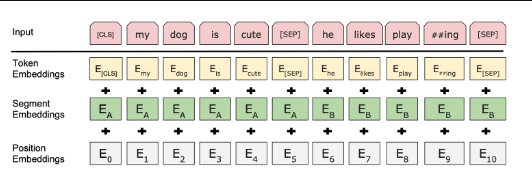



--------------------------------
*Token embedding*



In [59]:
class Token_emb(nn.Module):
  def __init__(self,vocab_size,d_model):
    super().__init__()
    self.emb = nn.Embedding(vocab_size,d_model)
  def forward(self,x):
    return self.emb(x)


In [63]:
Token_emb(1000,512)(torch.randint(20,(20,30))).shape

torch.Size([20, 30, 512])

--------------------------------
*Segment embedding*

In [22]:
class Segment_emb(nn.Module):
  def __init__(self,n_seg,d_model):
    self.emb = nn.Embedding(n_seg,d_model)
  def forward(self,x):
    return self.emb(x)

------------------
*Position embedding*

In [52]:
class Position_emb(nn.Module):
  def __init__(self,max_len,d_model):
    super().__init__()
    pe = torch.zeros(max_len,d_model).float()
    pe.require_grad = False

    position = torch.arange(0,max_len).float().unsqueeze(1)
    div = torch.pow(10000,torch.arange(0,d_model,2)/d_model)
    pe[:,0::2] = torch.sin(position/div)
    pe[:,1::2] = torch.cos(position/div)

    pe = pe.unsqueeze(0)
    self.register_buffer('pe',pe)
  def forward(self,x):
    return self.pe[:,:x.size(1)]

*Embedding*

In [64]:
class Embedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.token = Token_emb()
    self.seg = Segment_emb()
    self.pos = Position_emb()
  def forward(self, x):
    return self.token(x) + self.seg(x) + self.pos(x)


#### Encoder

In [ ]:
### Transformer cần biết đâu là dữ liệu đâu là MASK -> cần một mask_pad = 1 if [PAD] else 0

def mask_pad(seq_q,seq_k):
  batch_size, len_q = seq_q.size()
  batch_size, len_k = seq_k.size()

  pad_attn_mask = seq_k.data.eq(0).unsqueeze(1)


In [65]:
class ScaledDotProductAttention(nn.Module):
  def __init__(self,d_k):
    super().__init__()
    self.d_k = d_k
  def forward(self,q,k,v,mask = None):
    score = torch.matmul(q,k.transpose(-1,-2)) / torch.sqrt(self.d_k)
    if mask is not None:
      score.masked_fill(mask, 1e-9)
      attn = nn.Softmax(dim = 1)(score)
      output = torch.matmul(attn,v)
      return output,attn

In [ ]:
class MultiHeadAttention(nn.Module):
  def __init__(self,d_model,num_heads):
    super().__init__()
    assert d_model % num_heads == 0, "d_model phai chia het cho num_head"
    self.d_k = d_model//num_heads
    self.num_heads = num_heads
    self.score = ScaledDotProductAttention(d_k)

    self.w_q = nn.Linear(d_model,d_model)
    self.w_k = nn.Linear(d_model,d_model)
    self.w_v = nn.Linear(d_model,d_model)

    self.w_o = nn.Linear()

  def forward(self,q,k,v,mask = None):
    q = self.w_q(q)
    k = self.w_k(k)
    v = self.w_v(v)

    q = q.view(q.shape[0],q.shape[1],self.num_heads,self.d_k)
    k = k.view(k.shape[0],k.shape[1],self.num_heads,self.d_k)
    v = v.view(v.shape[0],v.shape[1],self.num_heads,self.d_k)

    x,attn = self.score(q,k,v,mask)
    self.dropout(x)
    x = x.transpose(1,2)
    return

In [ ]:
class Bert(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self):
    return

In [ ]:
class FeedForward(nn.Module):
  def __init__(self):
    super().__init__()
    self.ffn = nn.Linear()
  def forward(self,x):
    s


In [66]:
class Encoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.attn = MultiHeadAttention()
    self.ffn = FeedForward()
  def forward(self,x,mask = None):
    if mask is not None:
      output, attn = self.attn(x,x,x,mask)
    output = self.ffn(output)
    return output, attn


In [67]:
class BERT(nn.Module):
  def __init__(self):
    super().__init__()
  def forward(self):
    return 0

### Train

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 13-5)


In [ ]:
model = BERT()
batch = make_batch()
input_ids,segment_ids, mask_token, mask_pos, isNext = map(torch.LongTensor,zip(*batch))

for epoch in range(EPOCHS):
  optimizer.zero_grad()
  output,attn = model(input_ids,segment_ids,mask_pos)
  loss = loss_fn(output)

  if (epoch + 1) %10 ==0:
    print(f'Epoch: {epoch + 1} -> Cost: {loss}')
  loss.backward()
  optimizer.step()


In [ ]:
 ## Example
  input,ids , segment_ids, mask_token, mask_pos, isNext = map(torch.LongTensor,zip(batch[0]))
  print(text)